# import librairies

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.ensemble.forest import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import math
import sklearn.metrics as sklm
import xgboost as xgb
from sklearn.decomposition import PCA

import create_model as cm

# Read .csv files

In [ ]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_test_org = df_test.copy()

print(df_train.shape)
print(df_test.shape)

# Drop column: Id

In [ ]:
#Save the 'Id' column
train_ID = df_train['Id']
test_ID = df_test['Id']

df_train.drop('Id', axis=1, inplace=True)
df_test.drop('Id', axis=1, inplace=True)

print(df_train.shape)
print(df_test.shape)

# Drop Outliers

### According to GrLivArea

In [ ]:
fig, ax = plt.subplots()
ax.scatter(x = df_train['GrLivArea'], y = df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [ ]:
#Deleting outliers
df_train.drop(df_train[(df_train['GrLivArea']>4000) & (df_train['SalePrice']<300000)].index, inplace=True)
df_train.reset_index(drop=True, inplace=True)

#Check the graphic again
fig, ax = plt.subplots()
ax.scatter(df_train['GrLivArea'], df_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

### According to Tukey's Test (numerical features)

'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 
'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold'

In [ ]:
def Tukey_test(df, tar_list, k=3):
    df_new = pd.DataFrame()
    for col in tar_list:
        q1 = np.percentile(df[col].values, 25)
        q3 = np.percentile(df[col].values, 75)
        IQR = q3 - q1
        max_range = q3 + k*IQR
        min_range = q1 - k*IQR
        df_new[col] = df[col].clip(min_range, max_range)
    return df_new

In [ ]:
num_cols = ['LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
df_train[num_cols] = Tukey_test(df_train, num_cols)
df_train.shape

# Check duplicate values of every columns

In [ ]:
plt.figure(figsize=(20,10))
(df_train.apply(lambda x:x.unique().shape[0], axis=0)/df_train.shape[0]).plot(kind='bar', rot=100);

# Transforming numerical features that are actually categorical

In [ ]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_test['MSSubClass'] = df_test['MSSubClass'].apply(str)

df_train['MoSold'] = df_train['MoSold'].astype(str)
df_test['MoSold'] = df_test['MoSold'].astype(str)

# df_train['YrSold'] = df_train['YrSold'].astype(str)
# df_test['YrSold'] = df_test['YrSold'].astype(str)

# Handling missing data

### Check numbers of columns which have missing data

In [ ]:
df_train.isnull().any().sum()

In [ ]:
df_test.isnull().any().sum()

### Check counts of missing data

In [ ]:
train_null = df_train.isnull().sum(axis=0)
train_null = train_null[train_null != 0]
train_null

In [ ]:
test_null = df_test.isnull().sum(axis=0)
test_null = test_null[test_null != 0]
test_null

### Slice SalePrice of training data as y_train, and concatenate train and test data.

In [ ]:
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

df_train_y = df_train.SalePrice
train_y = df_train.SalePrice.values
print('train_y.shape:', train_y.shape)

# df_train['training_set'] = True
# df_test['training_set'] = False
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
all_data.shape

### Calculate counts of missing data and percentage

In [ ]:
total_missing = all_data.isnull().sum().sort_values(ascending=False)
percentage = ((all_data.isnull().sum()/all_data.isnull().count())*100).sort_values(ascending=False)

missing = pd.concat([total_missing, percentage],axis=1,keys=['Total','Percentage'])
missing.head(20)

In [ ]:
# 設定圖框大小
plt.subplots(figsize=(15,10))

# X軸標題旋轉90度
plt.xticks(rotation='90')

#劃出barplot
sns.barplot(x=total_missing.index[:20], y=percentage[:20])

#設定x, y標題
plt.xlabel('features')
plt.ylabel('percentage of missing data')

#設定title
plt.title('percent of missing data by feature')

plt.show()

### Drop columns if missing data more than 40%

In [ ]:
col_drop = missing[missing['Percentage']>=40].index
for col in col_drop:
    print('drop column:', str(col))

all_data = all_data.drop(col_drop, axis=1)
all_data.shape

### Filling in missing data

MSZoning:
    
Fill in the most common value 'RL'

In [ ]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

LotFrontage:

Median LotFrontage of the neighborhood

In [ ]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

Utilities:
    
remove this column(almost same category)

In [ ]:
all_data = all_data.drop(['Utilities'], axis=1)

Exterior1st, Exterior2nd:

Fill in the most common value

In [ ]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

MasVnrArea, MasVnrType:
    
MasVnrArea fill in 0, and MasVnrType fill in 'None' (no masonry veneer)

In [ ]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna('None')
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

Electrical:

Fill in the most common value 'SBrkr'

In [ ]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath and BsmtHalfBath:

fill in 0 (Because there is no basement!)

In [ ]:
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'BsmtFullBath', 'BsmtHalfBath', 'TotalBsmtSF'):
    all_data[col] = all_data[col].fillna(0)

# all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)

KitchenQual:
    
Fill in the most common value 'TA'

In [ ]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

Functional:
    
Feature description indicates that NA means typical

In [ ]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

GarageYrBlt, GarageArea, GarageCars: 
    
fill in 0 (Because there is no garage!)

In [ ]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

Fill in 'None'

FireplaceQu, GarageType, GarageFinish, GarageQual, GarageCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, MasVnrType, MSSubClass 

In [ ]:
# fill in 'None'
def fill_categorical(col):
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')
    else:
        print(col, 'not in dataset')

In [ ]:
col_categorical = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass']
for col in col_categorical:
    fill_categorical(col)

SaleType:

Fill in the most common value 'WD'

In [ ]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

### Check remaining missing value 

In [ ]:
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data

In [ ]:
all_data.shape

# Features Engineering

### Numerical feature selection according to correlation

In [ ]:
plt.figure(figsize=(10,10))
corr_matrix = df_train.corr()
filter_corr_feature = corr_matrix.index[abs(corr_matrix['SalePrice'])<0.5]
# sns.heatmap(df_train[filter_corr_feature].corr(), annot=True, cmap='winter');
filter_corr_feature

In [ ]:
all_data.drop(filter_corr_feature, axis=1, inplace=True)
all_data.shape

### Transforming hierarchical categories to numerical features

LotShape, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, KitchenQual, GarageFinish, GarageQual, GarageCond

In [ ]:
def fill_ordered_category(series, li):
    category_dict = {}
    li = li[::-1]
    for n in range(len(li)):
        category_dict[li[n]] = n
    series = series.map(category_dict)
    return series

In [ ]:
transform_dict = {
'LotShape': ['Reg', 'IR1', 'IR2', 'IR3'],
'LandSlope': ['Gtl', 'Mod', 'Sev'],
'ExterQual': ['Ex', 'Gd', 'TA', 'Fa'],
'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'None'],
'BsmtCond': ['Gd', 'TA', 'Fa', 'Po', 'None'],
'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'None'],
'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'],
'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'None'],
'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'None'],
'GarageFinish': ['Fin', 'RFn', 'Unf', 'None'],
'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'],
'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None']
}

for se in transform_dict:
    all_data[se] = fill_ordered_category(all_data[se], transform_dict[se])

all_data.shape

### One hot encoding

In [ ]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)
print(all_data.info())

### Get new train and test data

In [ ]:
df_train = all_data[:ntrain]
df_test = all_data[ntrain:]

print(df_train.shape)
print(df_test.shape)

In [ ]:
df_train_y.shape

In [ ]:
df_train = pd.concat((df_train, df_train_y), axis=1)
df_train.shape

### Define x and y

In [ ]:
x = df_train.iloc[:, :-1].values
y = train_y

### Data standardization

In [ ]:
scaler_train = StandardScaler()
scaler_train = scaler_train.fit(x)
x = scaler_train.transform(x)

scaler_test = StandardScaler()
scaler_test = scaler_test.fit(df_test)
test_x = scaler_test.transform(df_test)

### PCA

### Feature selection by Lasso (y is numeric)

In [ ]:
from sklearn.linear_model import LassoCV
# lassocv = LassoCV(alphas=[i for i in range(1, 1000)], max_iter=50000, normalize=False)
lassocv = LassoCV(max_iter=50000, normalize=False)
lassocv.fit(x, y)

mask = (lassocv.coef_ != 0)
x = x[:, mask]
x.shape

In [ ]:
lassocv.alpha_

In [ ]:
test_x = test_x[:, mask]
print(test_x.shape)

# Modeling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from my_toolbox import create_model as cm

In [2]:
df_train = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')
df_submit = pd.read_csv('../data/sample_submission.csv')

x = df_train.iloc[:, :-1].values
y = df_train.iloc[:, -1].values
test_x = df_test.values

In [3]:
model_obj = cm.modeling(x, y)

train_x (1168, 206)
train_y (1168,)
val_x (292, 206)
val_y (292,)


### linear

In [4]:
linear_model = model_obj.linear_modeling()
test_y = linear_model.predict(test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/linear_result.csv', index=False)

r2_score =  0.8853309324072576


### Lasso

In [5]:
lasso_model = model_obj.lasso_moedeling()
test_y = lasso_model.predict(test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/Lasso_result.csv', index=False)

r2_score =  0.8258084359332838


### Ridge

In [6]:
ridge_model = model_obj.ridge_modeling()
test_y = ridge_model.predict(test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/Ridge_result.csv', index=False)

r2_score =  0.8963862805361458


### Elastic Net

In [7]:
elasticnet_model = model_obj.elastic_modeling()
test_y = elasticnet_model.predict(test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/Elasticnet_result.csv', index=False)

r2_score =  0.8408716406847693


### Random Forest

In [9]:
rf_model = model_obj.rf_modeling()
test_y = rf_model.predict(test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/Forest_result.csv', index=False)

Root Mean Square Error =  35135.92654629597
r2_score =  0.7854501476411035


### XGBoost

[14:01:18] Tree method is selected to be 'hist', which uses a single updater grow_fast_histmaker.


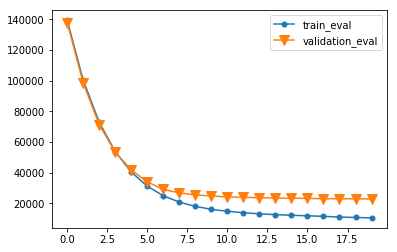

RMSE: [0]	eval-rmse:22788.652344
r-square for validation data is 0.9097467791665884
r-square for train data is 0.9803353649967526


In [8]:
xgb_model = model_obj.xgb_modeling()
xgb_test_x = xgb.DMatrix(test_x)
test_y = xgb_model.predict(xgb_test_x)
df_result = pd.DataFrame(df_submit['Id'])
df_result['SalePrice'] = test_y
df_result.to_csv('../submit/xgb_result.csv', index=False)